In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score

#Read CSV file
df = pd.read_csv('Kaggle/vehicle_maintenance_data_trucks_v3_withreportednobattery_noiseaddedbalanced2.csv')

#Create Labels and Input Data
y = df["Need_Maintenance"]
X = df.drop("Need_Maintenance",axis=1)

#Split the data into train and test
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = X_train_orig.copy()
X_test = X_test_orig.copy()


In [112]:
#Inspect X_train
X_train.head()

,Vehicle_Model,Mileage,Maintenance_History,Reported_Issues,Vehicle_Age,Fuel_Type,Transmission_Type,Engine_Size,Odometer_Reading,Last_Service_Date,Warranty_Expiry_Date,Owner_Type,Insurance_Premium,Service_History,Accident_History,Fuel_Efficiency,Tire_Condition,Brake_Condition
2271,Truck,72818.73780,Good,4,3,Diesel,Automatic,1000,81857.82828,19/5/2023,1/8/2024,First,19492.270590,1,1,11.690169,Worn Out,Good
3330,Truck,49111.21966,Good,5,4,Electric,Manual,1000,68644.29876,11/9/2023,13/8/2024,First,18495.250830,3,0,10.092347,New,New
1102,Truck,39235.65625,Good,0,8,Petrol,Manual,1000,93415.25632,6/8/2023,11/10/2025,Third,5806.258238,1,2,18.467269,Good,New
3007,Truck,60500.21977,Poor,4,9,Petrol,Manual,1500,18593.36121,22/12/2023,29/4/2024,Second,14315.979470,4,0,13.617149,Good,Good
3343,Truck,42452.14446,Poor,4,4,Petrol,Automatic,2500,60650.34012,11/11/2023,26/1/2026,Third,13198.018260,8,2,10.463815,Good,Worn Out


In [113]:
#Inspect X_test
X_test.head()

,Vehicle_Model,Mileage,Maintenance_History,Reported_Issues,Vehicle_Age,Fuel_Type,Transmission_Type,Engine_Size,Odometer_Reading,Last_Service_Date,Warranty_Expiry_Date,Owner_Type,Insurance_Premium,Service_History,Accident_History,Fuel_Efficiency,Tire_Condition,Brake_Condition
299,Truck,70076.25553,Poor,1,1,Diesel,Manual,2000,8078.784581,6/4/2023,14/1/2026,Third,19472.65740,5,2,11.112088,Worn Out,New
2240,Truck,61579.38072,Poor,5,9,Petrol,Automatic,800,8068.465026,15/10/2023,30/1/2025,Third,22071.42608,2,2,20.055055,New,New
2384,Truck,47999.96344,Good,5,6,Diesel,Automatic,800,73809.438070,11/7/2023,9/3/2026,First,20788.76477,2,1,11.050167,Good,Worn Out
3473,Truck,36553.98116,Good,0,2,Electric,Manual,800,81022.264420,8/10/2023,22/8/2024,Second,11723.31280,10,2,11.602223,Good,Worn Out
2614,Truck,32985.13565,Poor,3,8,Petrol,Manual,1000,69011.298120,8/11/2023,13/5/2024,Second,18047.10085,2,1,16.352690,Good,New


In [114]:
#convert last service date and warranty expiry date into date time
X_train["Last_Service_Date"] = pd.to_datetime(X_train["Last_Service_Date"],format="%d/%m/%Y")
X_train["Warranty_Expiry_Date"] = pd.to_datetime(X_train["Warranty_Expiry_Date"],format="%d/%m/%Y")

#Preprocess data such that it is express as warranty days remaining/days since last service. 
X_train["Days_since_last_service"] = (pd.Timestamp.today() - X_train["Last_Service_Date"]).dt.days
X_train["Warranty Days remaining"] = (X_train["Warranty_Expiry_Date"] - pd.Timestamp.today()).dt.days



X_test["Last_Service_Date"] = pd.to_datetime(X_test["Last_Service_Date"],format="%d/%m/%Y")
X_test["Warranty_Expiry_Date"] = pd.to_datetime(X_test["Warranty_Expiry_Date"],format="%d/%m/%Y")

X_test["Days_since_last_service"] = (pd.Timestamp.today() - X_test["Last_Service_Date"]).dt.days
X_test["Warranty Days remaining"] = (X_test["Warranty_Expiry_Date"] - pd.Timestamp.today()).dt.days


In [115]:
#Drop original last_service_date and warranty_expiry date cols
#Drop Vehicle Model as all truck
X_train = X_train.drop(columns = ['Last_Service_Date','Warranty_Expiry_Date','Vehicle_Model','Fuel_Type'], axis = 1)
X_test = X_test.drop(columns = ['Last_Service_Date','Warranty_Expiry_Date','Vehicle_Model','Fuel_Type'], axis = 1)


In [116]:
#Select categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include = ['int','float']).columns

In [117]:
oneHotEncoder = OneHotEncoder()

#Convert ordinal data into numerical categories
# pd.Categorical(df["Tire_Condition"],categories=["Worn Out","Good","New"],ordered=True) adds ordering to data Worn Out < Good < New but does not convert into binary
X_train["Tire_Condition"] = pd.Categorical(X_train["Tire_Condition"],categories=["Worn Out","Good","New"],ordered=True).codes
X_train["Brake_Condition"] = pd.Categorical(X_train["Brake_Condition"],categories=["Worn Out","Good","New"],ordered=True).codes
# X_train["Battery_Status"] = pd.Categorical(X_train["Battery_Status"],categories=["Weak","Good","New"],ordered=True).codes
X_train["Owner_Type"] = pd.Categorical(X_train["Owner_Type"],categories=["First","Second","Third"],ordered=True).codes
X_train["Maintenance_History"] = pd.Categorical(X_train["Maintenance_History"],categories=["Poor","Average","Good"],ordered=True).codes

X_test["Tire_Condition"] = pd.Categorical(X_test["Tire_Condition"],categories=["Worn Out","Good","New"],ordered=True).codes
X_test["Brake_Condition"] = pd.Categorical(X_test["Brake_Condition"],categories=["Worn Out","Good","New"],ordered=True).codes
# X_test["Battery_Status"] = pd.Categorical(X_test["Battery_Status"],categories=["Weak","Good","New"],ordered=True).codes
X_test["Owner_Type"] = pd.Categorical(X_test["Owner_Type"],categories=["First","Second","Third"],ordered=True).codes
X_test["Maintenance_History"] = pd.Categorical(X_test["Maintenance_History"],categories=["Poor","Average","Good"],ordered=True).codes


# "Battery_Status"
labelEncodedCols = ["Tire_Condition", "Brake_Condition","Owner_Type","Maintenance_History"]

#Essentially Transmission type and fuel type.
oneHotEncodedCols = list(set(categorical_cols) - set(labelEncodedCols))
X_train = pd.get_dummies(X_train,columns=oneHotEncodedCols,drop_first=True)
X_test = pd.get_dummies(X_test,columns=oneHotEncodedCols,drop_first=True)






In [118]:
X_train.head()

,Mileage,Maintenance_History,Reported_Issues,Vehicle_Age,Engine_Size,Odometer_Reading,Owner_Type,Insurance_Premium,Service_History,Accident_History,Fuel_Efficiency,Tire_Condition,Brake_Condition,Days_since_last_service,Warranty Days remaining,Transmission_Type_Manual
2271,72818.73780,2,4,3,1000,81857.82828,0,19492.270590,1,1,11.690169,0,1,526,-87,False
3330,49111.21966,2,5,4,1000,68644.29876,0,18495.250830,3,0,10.092347,2,2,411,-75,True
1102,39235.65625,2,0,8,1000,93415.25632,2,5806.258238,1,2,18.467269,1,2,447,349,True
3007,60500.21977,0,4,9,1500,18593.36121,1,14315.979470,4,0,13.617149,1,1,309,-181,True
3343,42452.14446,0,4,4,2500,60650.34012,2,13198.018260,8,2,10.463815,1,0,350,456,False


In [119]:
X_test.head()

,Mileage,Maintenance_History,Reported_Issues,Vehicle_Age,Engine_Size,Odometer_Reading,Owner_Type,Insurance_Premium,Service_History,Accident_History,Fuel_Efficiency,Tire_Condition,Brake_Condition,Days_since_last_service,Warranty Days remaining,Transmission_Type_Manual
299,70076.25553,0,1,1,2000,8078.784581,2,19472.65740,5,2,11.112088,0,2,569,444,True
2240,61579.38072,0,5,9,800,8068.465026,2,22071.42608,2,2,20.055055,2,2,377,95,False
2384,47999.96344,2,5,6,800,73809.438070,0,20788.76477,2,1,11.050167,1,0,473,498,False
3473,36553.98116,2,0,2,800,81022.264420,1,11723.31280,10,2,11.602223,1,0,384,-66,True
2614,32985.13565,0,3,8,1000,69011.298120,1,18047.10085,2,1,16.352690,1,2,353,-167,True


In [120]:
numerical_df = X_train[numerical_cols]

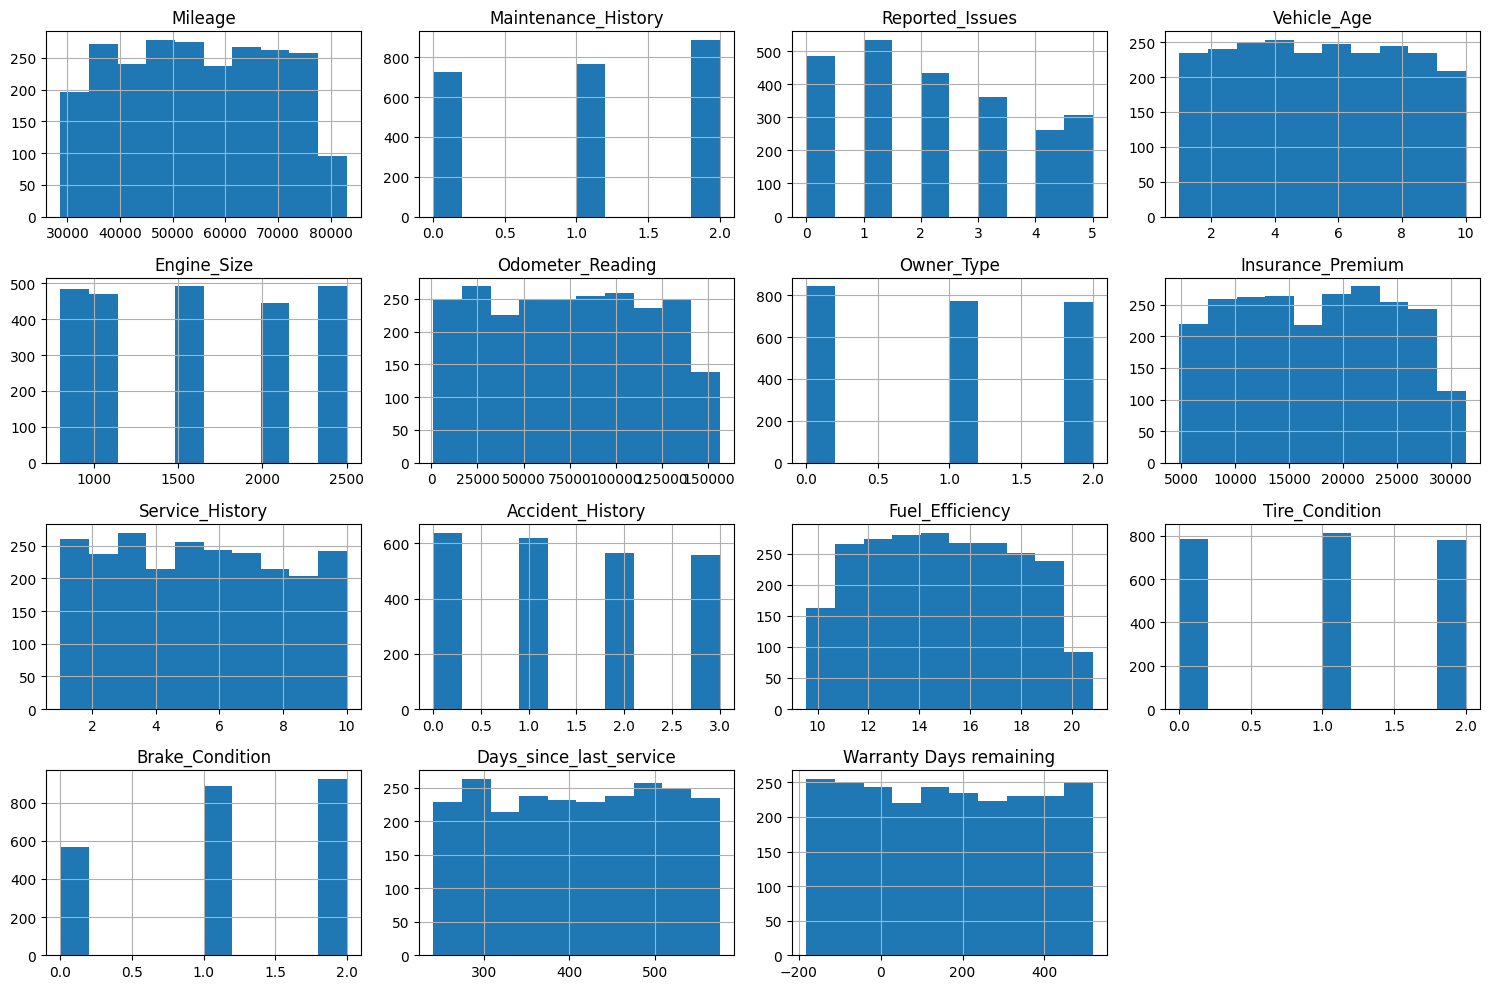

In [121]:
# import seaborn as sns
#Notice that the data does not follow normal distribution. 

X_train.hist(figsize=(15,10))
plt.tight_layout()



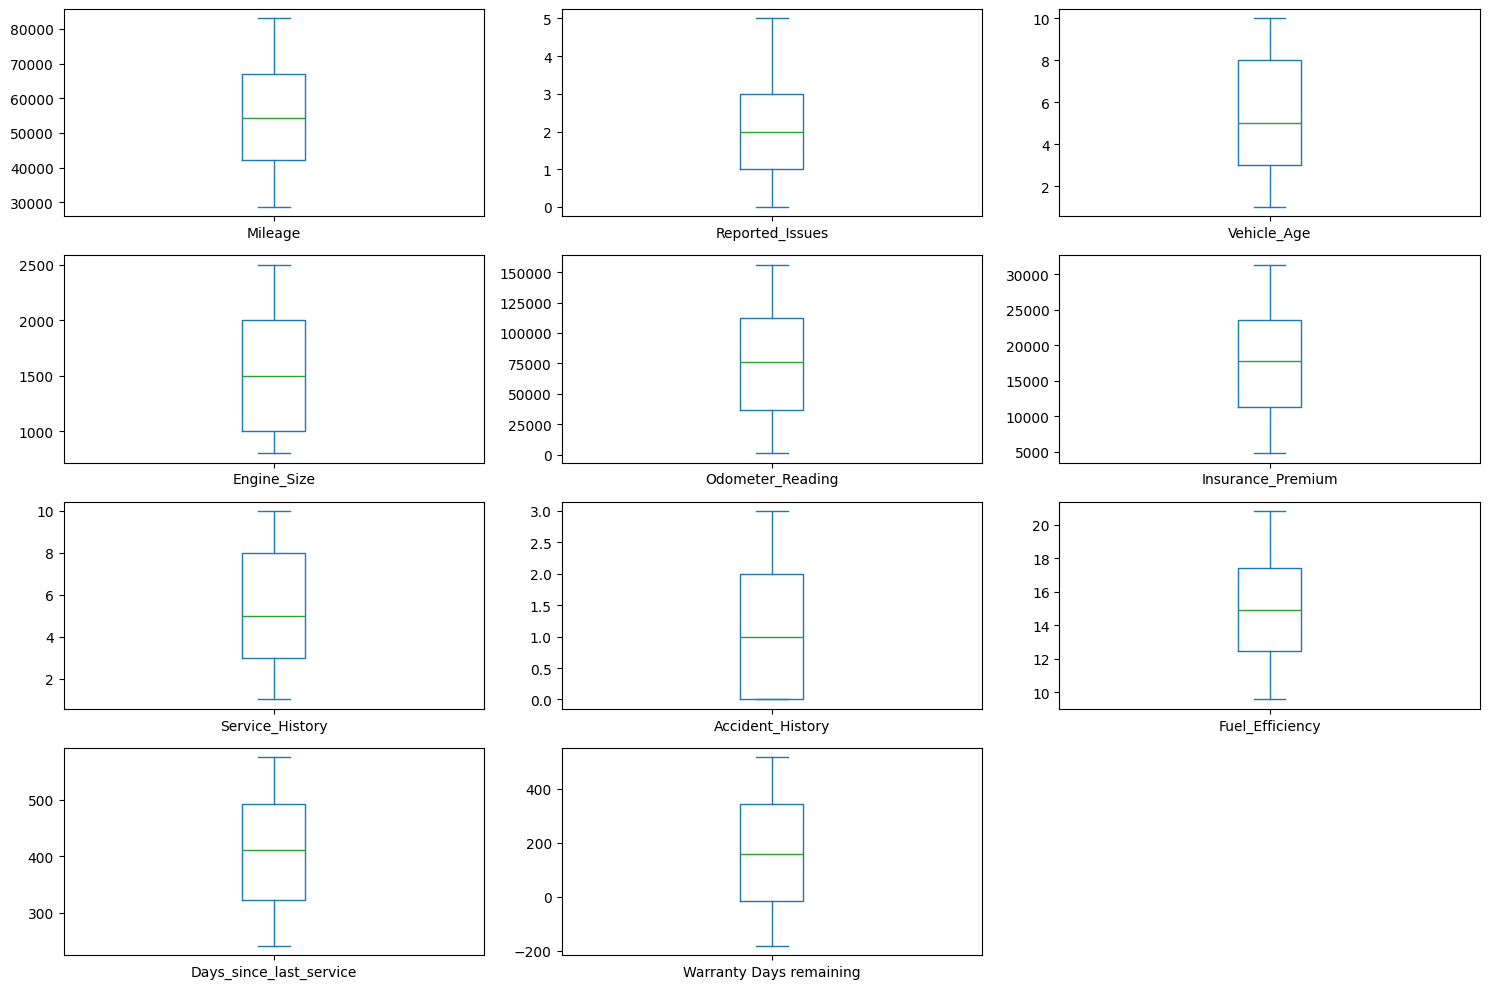

In [122]:
# Create boxplots for all numerical columns to check for outliers. Data suggests no outliers. 
numerical_data = X_train[numerical_cols]
numerical_data.plot(kind='box', subplots=True, layout=(4, 3), figsize=(15, 10), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

In [123]:
X_train.head()

,Mileage,Maintenance_History,Reported_Issues,Vehicle_Age,Engine_Size,Odometer_Reading,Owner_Type,Insurance_Premium,Service_History,Accident_History,Fuel_Efficiency,Tire_Condition,Brake_Condition,Days_since_last_service,Warranty Days remaining,Transmission_Type_Manual
2271,72818.73780,2,4,3,1000,81857.82828,0,19492.270590,1,1,11.690169,0,1,526,-87,False
3330,49111.21966,2,5,4,1000,68644.29876,0,18495.250830,3,0,10.092347,2,2,411,-75,True
1102,39235.65625,2,0,8,1000,93415.25632,2,5806.258238,1,2,18.467269,1,2,447,349,True
3007,60500.21977,0,4,9,1500,18593.36121,1,14315.979470,4,0,13.617149,1,1,309,-181,True
3343,42452.14446,0,4,4,2500,60650.34012,2,13198.018260,8,2,10.463815,1,0,350,456,False


In [124]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Mileage,2381.0,54726.187289,14403.142641,28668.888370,42326.928270,54322.36588,67048.558200,83028.487460
Maintenance_History,2381.0,1.066779,0.820530,0.000000,0.000000,1.00000,2.000000,2.000000
Reported_Issues,2381.0,2.124738,1.664250,0.000000,1.000000,2.00000,3.000000,5.000000
Vehicle_Age,2381.0,5.427971,2.831760,1.000000,3.000000,5.00000,8.000000,10.000000
Engine_Size,2381.0,1558.672827,631.362874,800.000000,1000.000000,1500.00000,2000.000000,2500.000000
Odometer_Reading,2381.0,75151.644955,43056.298479,1108.716518,36628.231640,75733.56162,112080.494700,156150.054000
Owner_Type,2381.0,0.968921,0.821891,0.000000,0.000000,1.00000,2.000000,2.000000
Insurance_Premium,2381.0,17495.073876,7185.396305,4823.226335,11315.516200,17806.08885,23534.280700,31343.006560
Service_History,2381.0,5.367913,2.879200,1.000000,3.000000,5.00000,8.000000,10.000000
Accident_History,2381.0,1.438051,1.119370,0.000000,0.000000,1.00000,2.000000,3.000000


In [125]:
X_train_cols = X_train.columns
print(X_train_cols)
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

X_train = pd.DataFrame(data=X_train,columns=X_train_cols)
X_test = pd.DataFrame(data=X_test,columns=X_train_cols)

Index(['Mileage', 'Maintenance_History', 'Reported_Issues', 'Vehicle_Age',
       'Engine_Size', 'Odometer_Reading', 'Owner_Type', 'Insurance_Premium',
       'Service_History', 'Accident_History', 'Fuel_Efficiency',
       'Tire_Condition', 'Brake_Condition', 'Days_since_last_service',
       'Warranty Days remaining', 'Transmission_Type_Manual'],
      dtype='object')


In [126]:
X_test.head()

,Mileage,Maintenance_History,Reported_Issues,Vehicle_Age,Engine_Size,Odometer_Reading,Owner_Type,Insurance_Premium,Service_History,Accident_History,Fuel_Efficiency,Tire_Condition,Brake_Condition,Days_since_last_service,Warranty Days remaining,Transmission_Type_Manual
299,70076.25553,0,1,1,2000,8078.784581,2,19472.65740,5,2,11.112088,0,2,569,444,True
2240,61579.38072,0,5,9,800,8068.465026,2,22071.42608,2,2,20.055055,2,2,377,95,False
2384,47999.96344,2,5,6,800,73809.438070,0,20788.76477,2,1,11.050167,1,0,473,498,False
3473,36553.98116,2,0,2,800,81022.264420,1,11723.31280,10,2,11.602223,1,0,384,-66,True
2614,32985.13565,0,3,8,1000,69011.298120,1,18047.10085,2,1,16.352690,1,2,353,-167,True


In [127]:
scaler = MinMaxScaler()

columns_to_scale = ["Mileage","Engine_Size","Odometer_Reading","Insurance_Premium","Fuel_Efficiency","Days_since_last_service","Warranty Days remaining"]

X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_scaled[columns_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.transform(X_test_scaled[columns_to_scale])



In [128]:
X_train_scaled.head()
X_test_scaled.head()

,Mileage,Maintenance_History,Reported_Issues,Vehicle_Age,Engine_Size,Odometer_Reading,Owner_Type,Insurance_Premium,Service_History,Accident_History,Fuel_Efficiency,Tire_Condition,Brake_Condition,Days_since_last_service,Warranty Days remaining,Transmission_Type_Manual
299,0.761731,0,1,1,0.705882,0.044956,2,0.552396,5,2,0.137922,0,2,0.979104,0.894286,True
2240,0.605422,0,5,9,0.000000,0.044890,2,0.650390,2,2,0.931868,2,2,0.405970,0.395714,False
2384,0.355615,2,5,6,0.000000,0.468912,0,0.602024,2,1,0.132425,1,0,0.692537,0.971429,False
3473,0.145054,2,0,2,0.000000,0.515434,1,0.260186,10,2,0.181436,1,0,0.426866,0.165714,True
2614,0.079402,0,3,8,0.117647,0.437964,1,0.498642,2,1,0.603177,1,2,0.334328,0.021429,True


In [38]:
# param_grid = {
#     'n_estimators': [200,400],         # Number of trees in the forest
#     'max_depth': [10, 20],             # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],         # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4],          # Minimum number of samples required to be at a leaf node
# }

# rf = RandomForestClassifier(random_state=42)

# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            cv=5, verbose=2)

# grid_search.fit(X_train, y_train)

# best_rf = grid_search.best_estimator_
# print("Best parameters found by GridSearchCV:", grid_search.best_params_)

In [24]:
# results_df = pd.DataFrame(grid_search.cv_results_)

# # Select only the most relevant columns for display
# results_table = results_df[['param_n_estimators', 'param_max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']]
# print(results_table)
# print(np.max(results_table["mean_test_score"]))
# print(np.min(results_table["mean_test_score"]))

    param_n_estimators  param_max_depth  mean_test_score  std_test_score  \
0                  200               10         0.939941        0.015531   
1                  400               10         0.938680        0.015235   
2                  200               10         0.938680        0.015804   
3                  400               10         0.939941        0.013721   
4                  200               10         0.938680        0.014523   
5                  400               10         0.937420        0.014525   
6                  200               10         0.938680        0.016460   
7                  400               10         0.939100        0.015725   
8                  200               10         0.937840        0.016948   
9                  400               10         0.937840        0.015983   
10                 200               10         0.938260        0.015247   
11                 400               10         0.938260        0.014955   
12          

In [129]:
#Random Forest Classifier
rf = RandomForestClassifier(n_estimators=400,random_state=42,max_depth=20,min_samples_leaf=1,min_samples_split=10)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_true=y_test,y_pred=y_pred_rf)
print(f"Accuracy: {acc_rf:.2f}")
print(classification_report(y_test,y_pred_rf))


y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
# Calculate the AUC-ROC score

auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"AUC-ROC Score: {auc_rf:.2f}")

# print(len(rf.feature_names_in_))
# print(len(rf.feature_importances_))
# pd.DataFrame(index=rf.feature_names_in_,data=rf.feature_importances_,columns=['importance']).sort_values(by="importance",ascending=False)


Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       534
           1       1.00      0.88      0.94       639

    accuracy                           0.94      1173
   macro avg       0.94      0.94      0.94      1173
weighted avg       0.94      0.94      0.94      1173

AUC-ROC Score: 0.95


In [22]:
#Uses scaled version of X_train.. Does not improve accurac. 
#Random Forest Classifier
# rf = RandomForestClassifier(n_estimators=400,random_state=42,max_depth=20,min_samples_leaf=1,min_samples_split=10)
# rf.fit(X_train_scaled,y_train)
# y_pred_rf = rf.predict(X_test_scaled)

# acc_rf = accuracy_score(y_true=y_test,y_pred=y_pred_rf)
# print(f"Accuracy: {acc_rf:.2f}")
# print(classification_report(y_test,y_pred_rf))


# y_pred_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]
# # Calculate the AUC-ROC score

# auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
# print(f"AUC-ROC Score: {auc_rf}")

# print(len(rf.feature_names_in_))
# print(len(rf.feature_importances_))
# pd.DataFrame(index=rf.feature_names_in_,data=rf.feature_importances_,columns=['importance']).sort_values(by="importance",ascending=False)


In [131]:
#To save data
import pickle

with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

# with open('rf_columns.pkl', 'wb') as columns_file:
#     pickle.dump(X_train.columns, columns_file)

In [132]:
with open('rf_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)



In [133]:
y_pred_rf = loaded_model.predict(X_test)

acc_rf = accuracy_score(y_true=y_test,y_pred=y_pred_rf)
print(f"Accuracy: {acc_rf:.2f}")
print(classification_report(y_test,y_pred_rf))

Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       534
           1       1.00      0.88      0.94       639

    accuracy                           0.94      1173
   macro avg       0.94      0.94      0.94      1173
weighted avg       0.94      0.94      0.94      1173



In [27]:
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],            # Inverse of regularization strength (smaller C -> stronger regularization)
#     'penalty': ['l1', 'l2', 'elasticnet', None],   # Regularization type
#     'max_iter': [100, 200, 300],              # Maximum number of iterations
# }

# lr = LogisticRegression(random_state=42)

# grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, 
#                            cv=5, verbose=2)

# grid_search.fit(X_train, y_train)

# print("Best parameters found by GridSearchCV:", grid_search.best_params_)

In [134]:

#Non convergence occuring because of multicollinearity
lr = LogisticRegression(solver='saga')
lr.fit(X_train_scaled,y_train)
y_pred_lr = lr.predict(X_test_scaled)

acc_lr = accuracy_score(y_true=y_test,y_pred=y_pred_lr)
print(f"Accuracy: {acc_lr:.2f}")
print(classification_report(y_test,y_pred_lr))

y_pred_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
# Calculate the AUC-ROC score

auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"AUC-ROC Score: {auc_lr:.2f}")



Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       534
           1       0.83      0.82      0.83       639

    accuracy                           0.81      1173
   macro avg       0.81      0.81      0.81      1173
weighted avg       0.81      0.81      0.81      1173

AUC-ROC Score: 0.89


In [135]:
svm = SVC(kernel='linear', C=1.0, random_state=42,probability=True)
svm.fit(X_train_scaled,y_train)
y_pred_svm = svm.predict(X_test_scaled)
acc_svm = accuracy_score(y_true=y_test,y_pred=y_pred_svm)
print(f"Accuracy: {acc_svm:.2f}")
print(classification_report(y_test,y_pred_svm))


y_pred_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]
# Calculate the AUC-ROC score

auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
print(f"AUC-ROC Score: {auc_svm}")

Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       534
           1       0.84      0.80      0.82       639

    accuracy                           0.81      1173
   macro avg       0.81      0.81      0.81      1173
weighted avg       0.81      0.81      0.81      1173

AUC-ROC Score: 0.8908875642536032


In [136]:

gbm = GradientBoostingClassifier()
gbm.fit(X_train, y_train)
y_pred_gbm = gbm.predict(X_test)
acc_gbm = accuracy_score(y_true=y_test,y_pred=y_pred_gbm)
print(f"Accuracy: {acc_gbm:.2f}")
print(classification_report(y_test,y_pred_gbm))



y_pred_proba_gbm = gbm.predict_proba(X_test)[:, 1]
# Calculate the AUC-ROC score

auc_gbm = roc_auc_score(y_test, y_pred_proba_gbm)
print(f"AUC-ROC Score: {auc_gbm:.2f}")

Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       534
           1       1.00      0.88      0.94       639

    accuracy                           0.94      1173
   macro avg       0.94      0.94      0.94      1173
weighted avg       0.94      0.94      0.94      1173

AUC-ROC Score: 0.95


In [164]:
#Using Scaled Data
# gbm = GradientBoostingClassifier()
# gbm.fit(X_train_scaled, y_train)
# y_pred_gbm = gbm.predict(X_test_scaled)
# acc_gbm = accuracy_score(y_true=y_test,y_pred=y_pred_gbm)
# print(f"Accuracy: {acc_gbm:.2f}")
# print(classification_report(y_test,y_pred_gbm))



# y_pred_proba_gbm = gbm.predict_proba(X_test_scaled)[:, 1]
# # Calculate the AUC-ROC score

# auc_gbm = roc_auc_score(y_test, y_pred_proba_gbm)
# print(f"AUC-ROC Score: {auc_gbm}")

Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       534
           1       1.00      0.88      0.94       639

    accuracy                           0.94      1173
   macro avg       0.94      0.94      0.94      1173
weighted avg       0.94      0.94      0.94      1173

AUC-ROC Score: 0.9492770187500366


In [33]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_true=y_test,y_pred=y_pred_dt)
print(f"Accuracy: {acc_dt:.2f}")
print(classification_report(y_test,y_pred_dt))


y_pred_proba_dt = dt.predict_proba(X_test)[:, 1]
# Calculate the AUC-ROC score

auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
print(f"AUC-ROC Score: {auc_dt}")

Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       534
           1       0.87      0.89      0.88       639

    accuracy                           0.86      1173
   macro avg       0.86      0.86      0.86      1173
weighted avg       0.86      0.86      0.86      1173

AUC-ROC Score: 0.860482495472209
